<a id="logreg"> </a>
## 1. Data Pre-Processing

**Import the required libraries**

In [1]:
# Importing libraries for data handling and processing
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics to evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


# To handle warning messages
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### Load the csv file

In [2]:
df= pd.read_csv('bank.csv')

In [3]:
df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,32,205,2,999,0,1.1,93.994,-36.4,4.858,5191.0,no
1,32,691,10,999,0,1.4,93.918,-42.7,4.960,5228.1,yes
2,45,45,8,999,0,1.4,93.444,-36.1,4.963,5228.1,no
3,33,400,1,5,2,-1.1,94.601,-49.5,1.032,4963.6,yes
4,47,903,2,999,1,-1.8,93.075,-47.1,1.415,5099.1,yes


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Prepare the data </b>
                </font>
            </div>
        </td>
    </tr>
</table>

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Perform an analysis for missing values </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [4]:
df.isnull().sum()

age               0
duration          0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Remove the outliers (if any) </b>
                </font>
            </div>
        </td>
    </tr>
</table>

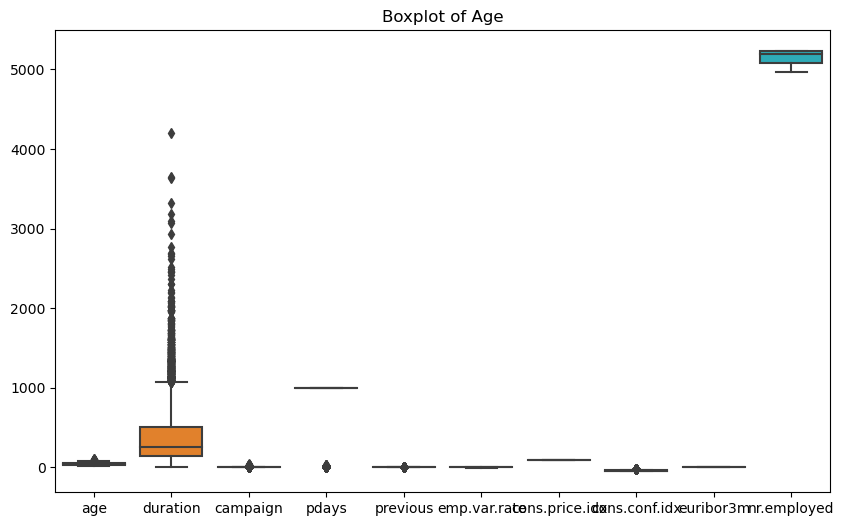

In [5]:
# Assuming 'age' and 'duration' are numerical columns you might want to check for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Boxplot of Age')
plt.show()

In [6]:
def remove_outliers(df1, column):
    Q1 = df1[column].quantile(0.25)
    Q3 = df1[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the outliers
    filtered_df = df1[(df1[column] >= lower_bound) & (df1[column] <= upper_bound)]
    return filtered_df

# Apply the function to the 'age' and 'duration' columns
data_clean = remove_outliers(df, 'pdays')
data_clean = remove_outliers(data_clean, 'duration')

# Check the shape of the data before and after
print("Original Data:", df.shape)
print("Data after removing outliers:", data_clean.shape)


Original Data: (9640, 11)
Data after removing outliers: (8182, 11)


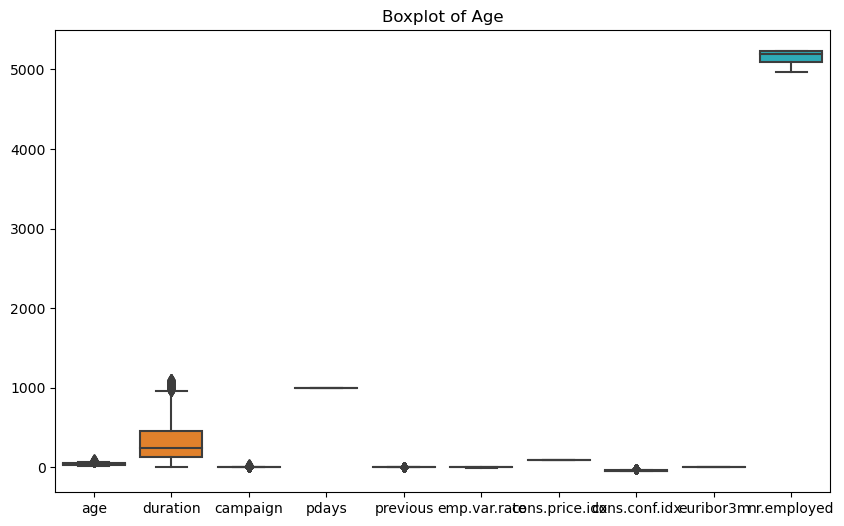

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_clean)
plt.title('Boxplot of Age')
plt.show()

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Separate the dependent and the independent variables. Also, in the target variable, replace yes with 0 and no with 1 </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [8]:
data_clean['y'].replace(
    {
        'no': 1,
        'yes': 0
    },
    inplace=True)

In [9]:
data_clean.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,32,205,2,999,0,1.1,93.994,-36.4,4.858,5191.0,1
1,32,691,10,999,0,1.4,93.918,-42.7,4.960,5228.1,0
2,45,45,8,999,0,1.4,93.444,-36.1,4.963,5228.1,1
4,47,903,2,999,1,-1.8,93.075,-47.1,1.415,5099.1,0
5,25,243,3,999,0,-1.8,92.843,-50.0,1.531,5099.1,0


In [10]:
X=data_clean.drop(['y'],axis='columns')
Y=data_clean['y']

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Remove the unnecessary variables that will not contribute to the model. </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [11]:
data_clean['pdays'].unique()
X=X.drop(['pdays'],axis='columns')

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Plot the distribution of all the numeric variables and find the value of skewness for each variable. </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [12]:
from scipy.stats import skew

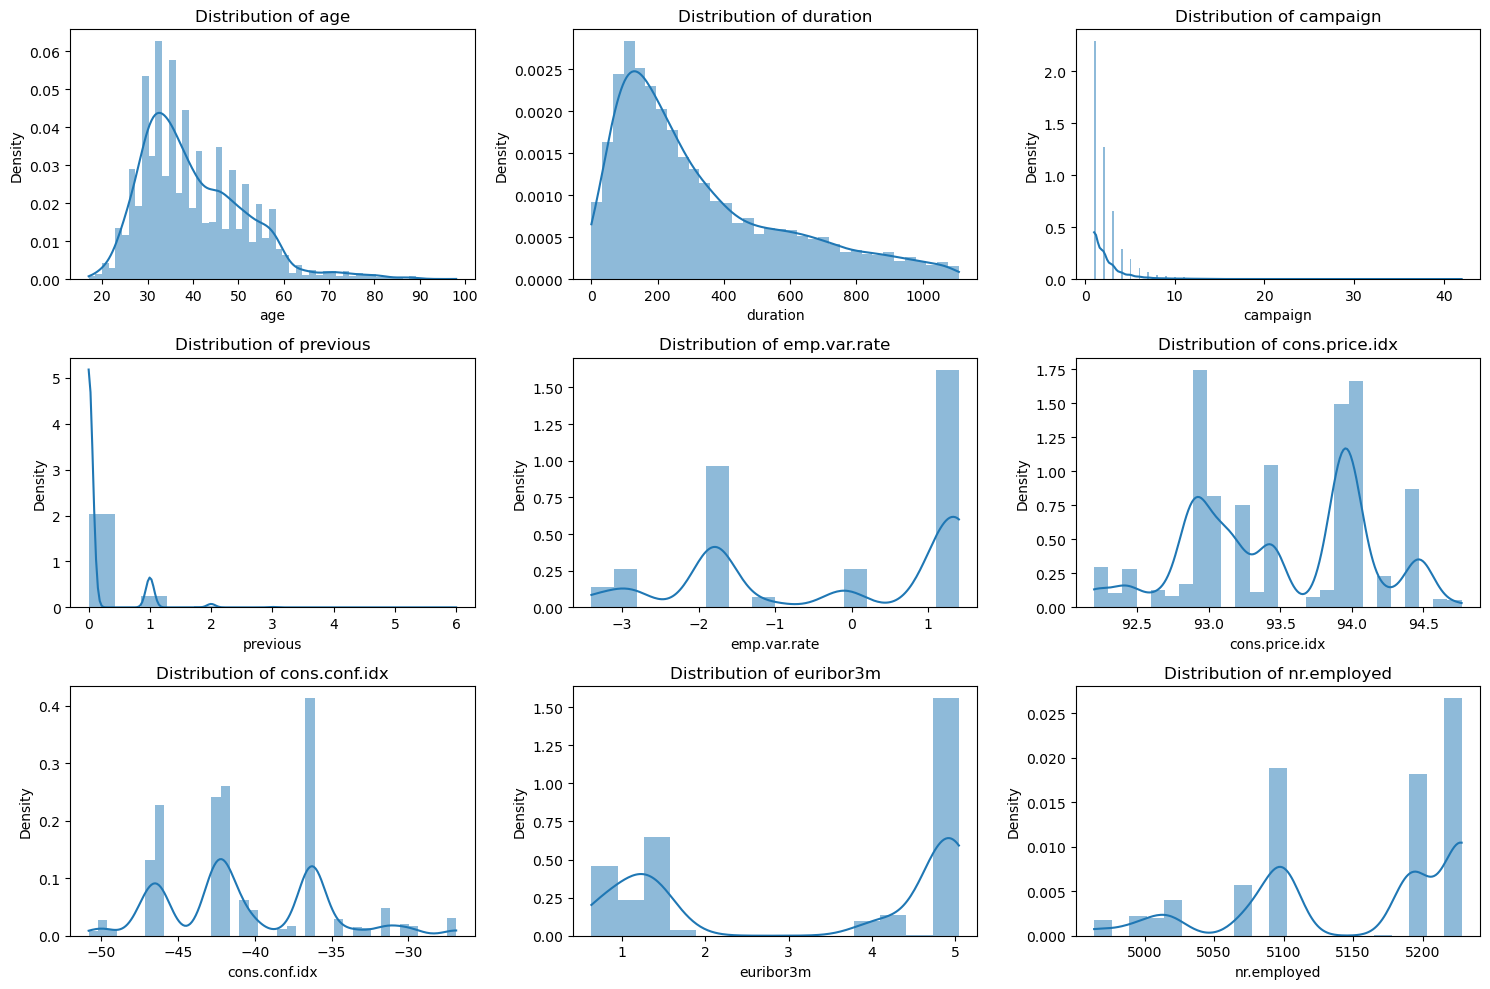

Skewness values for numeric columns:
age: 0.96
duration: 1.10
campaign: 5.00
previous: 3.49
emp.var.rate: -0.34
cons.price.idx: -0.10
cons.conf.idx: 0.39
euribor3m: -0.26
nr.employed: -0.64


In [13]:
# Identify numeric columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Initialize the plotting area
plt.figure(figsize=(15, 10))
total_cols = len(numeric_cols)
total_rows = total_cols // 3 + (total_cols % 3 > 0)

# Loop through numeric columns
for i, column in enumerate(numeric_cols):
    plt.subplot(total_rows, 3, i + 1)
    sns.histplot(X[column], kde=True, stat="density", linewidth=0)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Calculate and print skewness
skewness_values = {column: skew(X[column].dropna()) for column in numeric_cols}
print("Skewness values for numeric columns:")
for column, skewness in skewness_values.items():
    print(f"{column}: {skewness:.2f}")


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Plot the distribution of the target variable.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

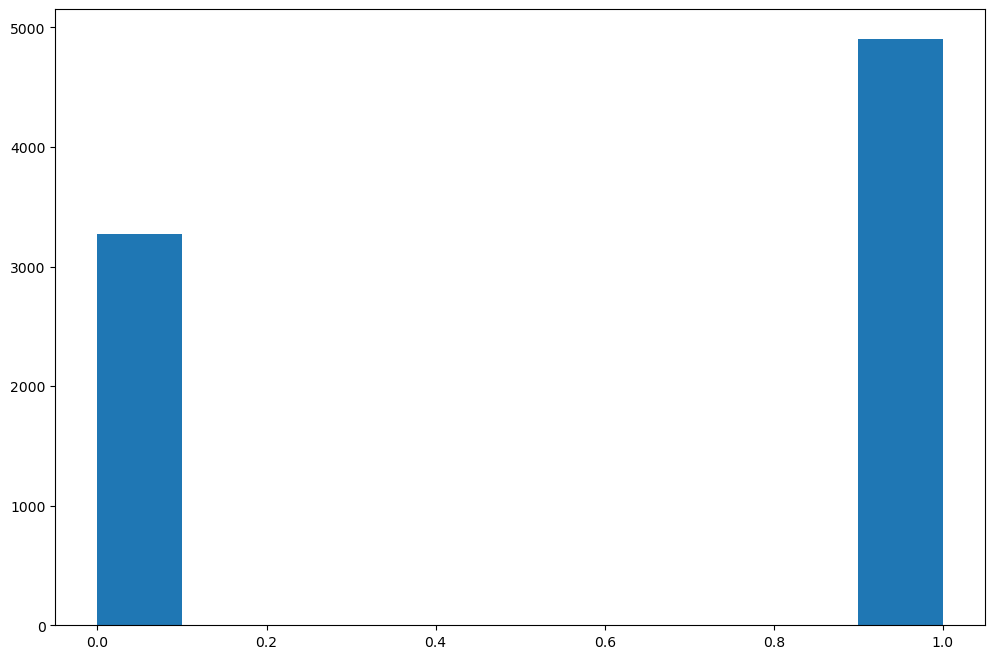

In [14]:
plt.figure(figsize=(12,8))
plt.hist(Y)
plt.show()

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Scale all the numeric variables using standard scalar.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [15]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
s=scaler.fit_transform(X)
scaled_data=pd.DataFrame(s,columns=X.columns)
scaled_data.head()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,-0.705365,-0.465753,-0.165214,-0.349673,0.819436,0.826230,0.804065,0.885831,0.514721
1,-0.705365,1.422699,3.022953,-0.349673,0.996304,0.702123,-0.421693,0.941180,0.982229
2,0.438145,-1.087465,2.225911,-0.349673,0.996304,-0.071910,0.862434,0.942808,0.982229
3,0.614070,2.246468,-0.165214,2.097742,-0.890281,-0.674480,-1.277778,-0.982471,-0.643340
4,-1.321101,-0.318096,0.233307,-0.349673,-0.890281,-1.053332,-1.842016,-0.919525,-0.643340


<a id="logreg"> </a>
## 2. Logistic regression model

In [16]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, Y, test_size=0.3, stratify=Y, random_state=2)

In [17]:
lr_model=LogisticRegression()

In [18]:
lr_model.fit(X_train,y_train)

LogisticRegression()

In [19]:
# let 'Y_pred' be the predicted values of y
Y_pred = lr_model.predict(X_test)

# print the y_pred
Y_pred

array([1, 0, 1, ..., 0, 1, 1])

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>How does a unit change in each feature influence the odds of a client subscribed a term deposit or not?</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [20]:
lr_model.coef_

array([[-0.0349841 , -2.00213752,  0.04375157,  0.19653414,  1.72908042,
        -0.21075006, -0.08618591, -1.07048104,  1.10608537]])

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Determining optimal threshold</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [21]:
from sklearn.metrics import precision_recall_curve, f1_score

# Obtain predicted probabilities for each class
y_pred_proba = lr_model.predict_proba(X_test)

# Assuming y_test and y_pred_proba are your true labels and predicted probabilities respectively
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])

# Calculate F1-score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the optimal threshold that maximizes the F1-score
optimal_threshold = thresholds[np.argmax(f1_scores)]

print("Optimal Threshold:", optimal_threshold)

Optimal Threshold: 0.49668984167134234


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                        <b>For the full model, calculate the accuracy manually using the confusion matrix. Consider 0.5 as the probability threshold.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [22]:
#Accuracy calculated for the full model using Accuracy Score Metric
from sklearn.metrics import accuracy_score
#accuracy on training data
X_train_prediction = lr_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, y_train) 
print('Accuracy on Training data : ', training_data_accuracy)
# accuracy on test data
X_test_prediction = lr_model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print('Accuracy on Test data : ', test_data_accuracy)

Accuracy on Training data :  0.8426750480181596
Accuracy on Test data :  0.8427698574338085


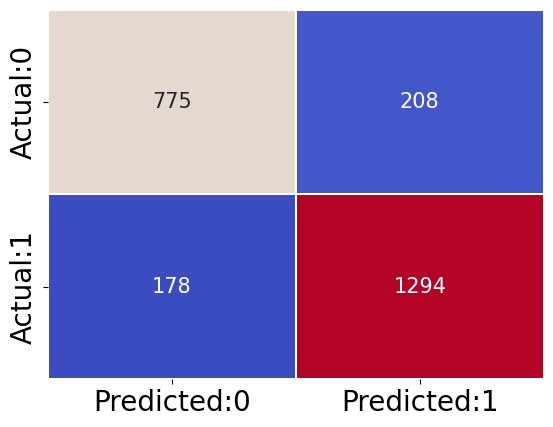

Accuracy (Manually Calculated): 0.8427698574338085


In [23]:
#Accuracy calculated for the full model manually using the confusion matrix

#plot the confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_proba are your true labels and predicted probabilities respectively
y_pred_binary = (y_pred_proba[:, 1] >= 0.5).astype(int)  # Convert probabilities to binary predictions

# create a confusion matrix
# pass the actual and predicted target values to the confusion_matrix()
cm = confusion_matrix(y_test, y_pred_binary)

# label the confusion matrix  
# pass the matrix as 'data'
# pass the required column names to the parameter, 'columns'
# pass the required row names to the parameter, 'index'
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

# plot a heatmap to visualize the confusion matrix
# 'annot' prints the value of each grid 
# 'fmt = d' returns the integer value in each grid
# 'cmap' assigns color to each grid
# as we do not require different colors for each grid in the heatmap,
# use 'ListedColormap' to assign the specified color to the grid
# 'cbar = False' will not return the color bar to the right side of the heatmap
# 'linewidths' assigns the width to the line that divides each grid
# 'annot_kws = {'size':25})' assigns the font size of the annotated text 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'coolwarm', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':15})

# set the font size of x-axis ticks using 'fontsize'
plt.xticks(fontsize = 20)

# set the font size of y-axis ticks using 'fontsize'
plt.yticks(fontsize = 20)

# display the plot
plt.show()

# Extract values from confusion matrix
TN, FP, FN, TP = cm.ravel()

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

print("Accuracy (Manually Calculated):", accuracy)

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Calculate value of kappa for the full model . Consider threshold value as 0.18</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [24]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Get probabilities for the positive class
probabilities = lr_model.predict_proba(X_test)[:, 1]

# Apply threshold
predictions = (probabilities >= 0.18).astype(int)


# Calculate Kappa statistic
kappa = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa: {kappa:.2f}")



Cohen's Kappa: 0.49


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Calculate the cross entropy for the logistic regression model.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [25]:
from sklearn.metrics import log_loss

# Calculate log loss
cross_entropy = log_loss(y_test, probabilities)

print(f"Cross-Entropy (Log Loss): {cross_entropy:.4f}")


Cross-Entropy (Log Loss): 0.3628


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Predict whether a client subscribed a term deposit or not. For the logistic regression model find the following:<br> <ol type = "a">
                        <li> Precision </li>
                        <li> Recall</li>   
                        <li> F<sub>1</sub> score </li>
                        </ol>
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [26]:
from sklearn.metrics import precision_score

In [27]:
# precision for training data predictions
precision_train = precision_score(y_train, X_train_prediction)
print('Training data Precision =', precision_train)

Training data Precision = 0.8647092688543466


In [28]:
# precision for test data predictions
precision_test = precision_score(y_test, X_test_prediction)
print('Test data Precision =', precision_test)

Test data Precision = 0.8615179760319573


In [29]:
from sklearn.metrics import recall_score

In [30]:
# recall for training data predictions
recall_train = recall_score(y_train, X_train_prediction)
print('Training data Recall =', recall_train)

Training data Recall = 0.8745269286754003


In [31]:
# recall for test data predictions
recall_test = recall_score(y_test, X_test_prediction)
print('Test data Recall =', recall_test)

Test data Recall = 0.8790760869565217


In [32]:
from sklearn.metrics import f1_score

In [33]:
# F1 score for training data predictions
f1_score_train = f1_score(y_train, X_train_prediction)
print('Training data F1 Score =', f1_score_train)

Training data F1 Score = 0.8695903893472282


In [34]:
# F1 Score for test data predictions
f1_score_test = recall_score(y_test, X_test_prediction)
print('Test data F1 Score =', f1_score_test)

Test data F1 Score = 0.8790760869565217


In [35]:
# calculate various performance measures
from sklearn.metrics import classification_report
acc_table = classification_report(y_test, X_test_prediction)

# print the table
print(acc_table)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       983
           1       0.86      0.88      0.87      1472

    accuracy                           0.84      2455
   macro avg       0.84      0.83      0.84      2455
weighted avg       0.84      0.84      0.84      2455



In [36]:
scores = {
    'Logistic Regression': {
        'Accuracy':{
            'Train': training_data_accuracy,
            'Test': test_data_accuracy,
        },
        'Precision':{
            'Train': precision_train,
            'Test': precision_test,
        },
        'F-1 Score':{
            'Train': f1_score_train,
            'Test': f1_score_test,
        },
        'Recall':{
            'Train': recall_train,
            'Test': recall_test,
        },
    }
}

In [77]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def roc_auc_curve_generate(r_model,X_train, X_test, y_train, y_test,name):
    y_pred_test = r_model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
    plt.figure(figsize=(8,4))

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC curve '+name+' Classifier (Full Model)', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    # add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    # 's' is the text 
    # use round() to round-off the AUC score upto 4 digits
    plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, y_pred_test),4)))
                               
    # plot the grid
    plt.grid(True)

## 3.Build a Decision Tree model and generate a classification report.



In [38]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree model
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred)

print("Classification Report for Decision Tree Model:")
print(report)


Classification Report for Decision Tree Model:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       983
           1       0.87      0.85      0.86      1472

    accuracy                           0.84      2455
   macro avg       0.83      0.83      0.83      2455
weighted avg       0.84      0.84      0.84      2455



In [39]:
#import matplotlib.pyplot as plt
#from sklearn import tree
# Setting dpi = 300 to make image clearer than default
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,8), dpi=300)
#labels = X_train.columns

#tree.plot_tree(dt_classifier, feature_names =labels.values.tolist(), class_names = ["0","1"],filled = True);

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Determining optimal hyperparameters using GridSearchCV</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [40]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their values
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV with the DecisionTreeClassifier and the parameter grid
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)


Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Accuracy: 0.8611830784120962


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Compare the Full model and optimized model using model performance metrics
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [41]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print("TRAINIG RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

    print("TESTING RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

In [42]:
# Fit the full model
dt_classifier.fit(X_train, y_train)

# Evaluate the full model
full_model_metrics_dt = evaluate_model(dt_classifier,X_train, X_test, y_train, y_test)

# Evaluate the optimized model
optimized_model_metrics_dt = evaluate_model(grid_search.best_estimator_,X_train, X_test, y_train, y_test)



TRAINIG RESULTS: 
CONFUSION MATRIX:
[[2292    0]
 [   0 3435]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    2292.0  3435.0       1.0     5727.0        5727.0
TESTING RESULTS: 
CONFUSION MATRIX:
[[ 799  184]
 [ 214 1258]]
ACCURACY SCORE:
0.8379
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.788746     0.872399  0.837882     0.830573      0.838904
recall       0.812818     0.854620  0.837882     0.833719      0.837882
f1-score     0.800601     0.863418  0.837882     0.832010      0.838266
support    983.000000  1472.000000  0.837882  2455.000000   2455.000000
TRAINIG RESULTS: 
CONFUSION MATRIX:
[[2100  192]
 [ 367 3068]]
ACCURACY SCORE:
0.9024
CLASSIFICATION REPORT:
        

In [43]:
#Adding all the classification report for summarising the evaluation 
scores['DT-Full'] = {
    
        'Accuracy': {
            'Train': accuracy_score(y_train, dt_classifier.predict(X_train)),
            'Test': accuracy_score(y_test, dt_classifier.predict(X_test)),
        },
        'Precision': {
            'Train': precision_score(y_train, dt_classifier.predict(X_train)),
            'Test': precision_score(y_test, dt_classifier.predict(X_test)),
        },
        'F-1 Score': {
            'Train': f1_score(y_train, dt_classifier.predict(X_train)),
            'Test': f1_score(y_test, dt_classifier.predict(X_test)),
        },
        'Recall': {
            'Train': recall_score(y_train, dt_classifier.predict(X_train)),
            'Test': recall_score(y_test, dt_classifier.predict(X_test)),
        }
    
}
scores['DT-Optimized'] = {
    
        'Accuracy': {
            'Train': accuracy_score(y_train, grid_search.best_estimator_.predict(X_train)),
            'Test': accuracy_score(y_test, grid_search.best_estimator_.predict(X_test)),
        },
        'Precision': {
            'Train': precision_score(y_train, grid_search.best_estimator_.predict(X_train)),
            'Test': precision_score(y_test, grid_search.best_estimator_.predict(X_test)),
        }, 
        'F-1 Score': {
            'Train': f1_score(y_train, grid_search.best_estimator_.predict(X_train)),
            'Test': f1_score(y_test, grid_search.best_estimator_.predict(X_test)),
        },
        'Recall': {
            'Train': recall_score(y_train, grid_search.best_estimator_.predict(X_train)),
            'Test': recall_score(y_test, grid_search.best_estimator_.predict(X_test)),
        },
    
}

## 4.Build a Random Forest model with n_estimators=30 and generate a classification report.



In [44]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42, n_estimators=30)
rf_clf.fit(X_train, y_train)
evaluate_model(rf_clf, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[2291    1]
 [   6 3429]]
ACCURACY SCORE:
0.9988
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.997388     0.999708  0.998778     0.998548      0.998780
recall        0.999564     0.998253  0.998778     0.998908      0.998778
f1-score      0.998475     0.998980  0.998778     0.998727      0.998778
support    2292.000000  3435.000000  0.998778  5727.000000   5727.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[ 891   92]
 [ 203 1269]]
ACCURACY SCORE:
0.8798
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.814442     0.932403  0.879837     0.873423      0.885171
recall       0.906409     0.862092  0.879837     0.884251      0.879837
f1-score     0.857968     0.895870  0.879837     0.876919      0.880694
support    983.000000  1472.000000  0.879837  2455.000000   2455.000000


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Determining optimal hyperparameters using GridSearchCV</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [45]:
tuned_paramaters = [{'criterion': ['entropy', 'gini'],
                     'max_depth': [10, 15, 20],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2, 5, 8, 11],
                     'min_samples_leaf': [1, 5, 9],
                     'max_leaf_nodes': [2, 5, 8, 11]}]
rf_clf_tuned = GridSearchCV(estimator = rf_clf,
                       param_grid = tuned_paramaters,
                       cv = 5)
rf_clf_tuned.fit(X_train, y_train)

print('Best parameters for random forest classifier: ', rf_clf_tuned.best_params_, '\n')

Best parameters for random forest classifier:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 11, 'min_samples_leaf': 9, 'min_samples_split': 2} 



<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Compare the Full model and optimized model using model performance metrics
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [46]:
# Evaluate the full model
full_model_metrics_rf = evaluate_model(rf_clf,X_train, X_test, y_train, y_test)

# Evaluate the optimized model
optimized_model_metrics_rf = evaluate_model(rf_clf_tuned.best_estimator_,X_train, X_test, y_train, y_test)



TRAINIG RESULTS: 
CONFUSION MATRIX:
[[2291    1]
 [   6 3429]]
ACCURACY SCORE:
0.9988
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.997388     0.999708  0.998778     0.998548      0.998780
recall        0.999564     0.998253  0.998778     0.998908      0.998778
f1-score      0.998475     0.998980  0.998778     0.998727      0.998778
support    2292.000000  3435.000000  0.998778  5727.000000   5727.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[ 891   92]
 [ 203 1269]]
ACCURACY SCORE:
0.8798
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.814442     0.932403  0.879837     0.873423      0.885171
recall       0.906409     0.862092  0.879837     0.884251      0.879837
f1-score     0.857968     0.895870  0.879837     0.876919      0.880694
support    983.000000  1472.000000  0.879837  2455.000000   2455.000000
TRAINIG RESULTS: 
CONFUSION MATRIX:
[[2084  208]
 [ 556 2

In [47]:
#Adding all the classification report for summarising the evaluation 
scores['Random Forest-Full'] = {
    
        'Accuracy': {
            'Train': accuracy_score(y_train, rf_clf.predict(X_train)),
            'Test': accuracy_score(y_test, rf_clf.predict(X_test)),
        },
        'Precision': {
            'Train': precision_score(y_train, rf_clf.predict(X_train)),
            'Test': precision_score(y_test, rf_clf.predict(X_test)),
        },
        'F-1 Score': {
            'Train': f1_score(y_train, rf_clf.predict(X_train)),
            'Test': f1_score(y_test, rf_clf.predict(X_test)),
        },
        'Recall': {
            'Train': recall_score(y_train, rf_clf.predict(X_train)),
            'Test': recall_score(y_test, rf_clf.predict(X_test)),
        }
    
}
scores['Random Forest-Optimized'] = {
    
        'Accuracy': {
            'Train': accuracy_score(y_train, rf_clf_tuned.best_estimator_.predict(X_train)),
            'Test': accuracy_score(y_test, rf_clf_tuned.best_estimator_.predict(X_test)),
        },
        'Precision': {
            'Train': precision_score(y_train, rf_clf_tuned.best_estimator_.predict(X_train)),
            'Test': precision_score(y_test, rf_clf_tuned.best_estimator_.predict(X_test)),
        }, 
        'F-1 Score': {
            'Train': f1_score(y_train, rf_clf_tuned.best_estimator_.predict(X_train)),
            'Test': f1_score(y_test, rf_clf_tuned.best_estimator_.predict(X_test)),
        },
        'Recall': {
            'Train': recall_score(y_train, rf_clf_tuned.best_estimator_.predict(X_train)),
            'Test': recall_score(y_test, rf_clf_tuned.best_estimator_.predict(X_test)),
        },
    
}

## 5.Build the XGBoost model with a learning rate of 0.4 and gamma equal to 3. Calculate the accuracy by plotting the confusion matrix

In [48]:
from xgboost import XGBClassifier
from sklearn.metrics import r2_score,mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [49]:
xgboost = XGBClassifier(learning_rate = 0.4,gamma=3)
xgboost.fit(X_train,y_train)
evaluate_model(xgboost, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[2100  192]
 [ 421 3014]]
ACCURACY SCORE:
0.8930
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.833003     0.940112  0.892963     0.886558      0.897246
recall        0.916230     0.877438  0.892963     0.896834      0.892963
f1-score      0.872637     0.907695  0.892963     0.890166      0.893664
support    2292.000000  3435.000000  0.892963  5727.000000   5727.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[ 904   79]
 [ 217 1255]]
ACCURACY SCORE:
0.8794
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.806423     0.940780   0.87943     0.873601      0.886982
recall       0.919634     0.852582   0.87943     0.886108      0.879430
f1-score     0.859316     0.894512   0.87943     0.876914      0.880419
support    983.000000  1472.000000   0.87943  2455.000000   2455.000000


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Determining optimal hyperparameters using GridSearchCV</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [50]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

model = XGBClassifier()

grid_search_xgb = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2)

grid_search_xgb.fit(X_train, y_train)

print("Best parameters:", grid_search_xgb.best_params_)
best_model = grid_search_xgb.best_estimator_



Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_dept

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Compare the Full model and optimized model using model performance metrics
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [51]:
# Evaluate the full model
full_model_metrics_xgb = evaluate_model(xgboost,X_train, X_test, y_train, y_test)

# Evaluate the optimized model
optimized_model_metrics_xgb = evaluate_model(grid_search_xgb.best_estimator_,X_train, X_test, y_train, y_test)



TRAINIG RESULTS: 
CONFUSION MATRIX:
[[2100  192]
 [ 421 3014]]
ACCURACY SCORE:
0.8930
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.833003     0.940112  0.892963     0.886558      0.897246
recall        0.916230     0.877438  0.892963     0.896834      0.892963
f1-score      0.872637     0.907695  0.892963     0.890166      0.893664
support    2292.000000  3435.000000  0.892963  5727.000000   5727.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[ 904   79]
 [ 217 1255]]
ACCURACY SCORE:
0.8794
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.806423     0.940780   0.87943     0.873601      0.886982
recall       0.919634     0.852582   0.87943     0.886108      0.879430
f1-score     0.859316     0.894512   0.87943     0.876914      0.880419
support    983.000000  1472.000000   0.87943  2455.000000   2455.000000
TRAINIG RESULTS: 
CONFUSION MATRIX:
[[2164  128]
 [ 288 3

In [52]:
#Adding all the classification report for summarising the evaluation 
scores['XGBoost-Full'] = {
    
        'Accuracy': {
            'Train': accuracy_score(y_train, xgboost.predict(X_train)),
            'Test': accuracy_score(y_test, xgboost.predict(X_test)),
        },
        'Precision': {
            'Train': precision_score(y_train, xgboost.predict(X_train)),
            'Test': precision_score(y_test, xgboost.predict(X_test)),
        },
        'F-1 Score': {
            'Train': f1_score(y_train, xgboost.predict(X_train)),
            'Test': f1_score(y_test, xgboost.predict(X_test)),
        },
        'Recall': {
            'Train': recall_score(y_train, xgboost.predict(X_train)),
            'Test': recall_score(y_test, xgboost.predict(X_test)),
        }
    
}
scores['XGBoost-Optimized'] = {
    
        'Accuracy': {
            'Train': accuracy_score(y_train, grid_search_xgb.best_estimator_.predict(X_train)),
            'Test': accuracy_score(y_test, grid_search_xgb.best_estimator_.predict(X_test)),
        },
        'Precision': {
            'Train': precision_score(y_train, grid_search_xgb.best_estimator_.predict(X_train)),
            'Test': precision_score(y_test, grid_search_xgb.best_estimator_.predict(X_test)),
        }, 
        'F-1 Score': {
            'Train': f1_score(y_train, grid_search_xgb.best_estimator_.predict(X_train)),
            'Test': f1_score(y_test, grid_search_xgb.best_estimator_.predict(X_test)),
        },
        'Recall': {
            'Train': recall_score(y_train, grid_search_xgb.best_estimator_.predict(X_train)),
            'Test': recall_score(y_test, grid_search_xgb.best_estimator_.predict(X_test)),
        },
    
}

## 6.Build the K - Nearest Neighbor Model

In [53]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [54]:
evaluate_model(knn, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[2292    0]
 [   0 3435]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    2292.0  3435.0       1.0     5727.0        5727.0
TESTING RESULTS: 
CONFUSION MATRIX:
[[ 772  211]
 [ 233 1239]]
ACCURACY SCORE:
0.8191
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.768159     0.854483  0.819145     0.811321      0.819918
recall       0.785351     0.841712  0.819145     0.813531      0.819145
f1-score     0.776660     0.848049  0.819145     0.812355      0.819464
support    983.000000  1472.000000  0.819145  2455.000000   2455.000000


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Determining optimal K-Value using Elbow Curve Method</b>
                </font>
            </div>
        </td>
    </tr>
</table>

Text(0, 0.5, 'Error Rate')

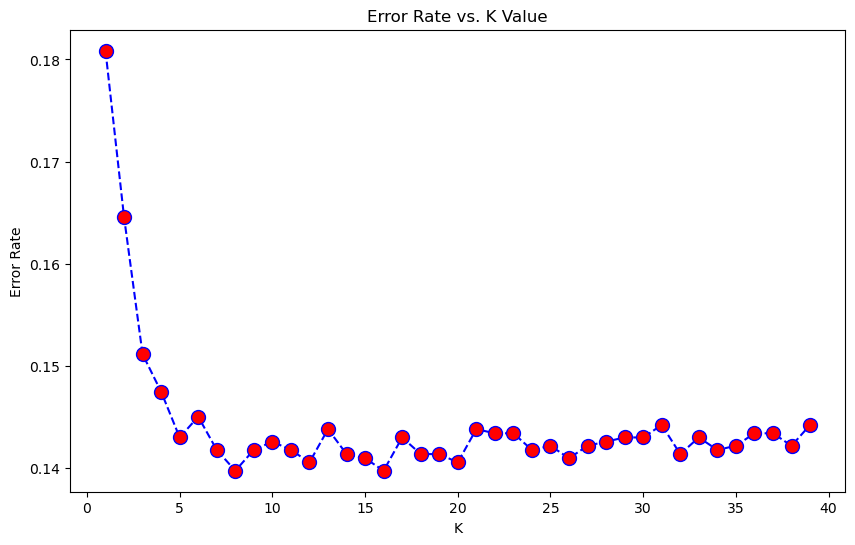

In [55]:
error_rate = []

# Will take some time
for i in range(1,40):

    knn_opt = KNeighborsClassifier(n_neighbors=i)
    knn_opt.fit(X_train,y_train)
    pred_i = knn_opt.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Compare the Full model and optimized model using model performance metrics
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [56]:
knn_opt = KNeighborsClassifier(n_neighbors=7)
knn_opt.fit(X_train,y_train)
full_model_metrics_knn=evaluate_model(knn, X_train, X_test, y_train, y_test)
optimized_model_metrics_knn=evaluate_model(knn_opt, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[2292    0]
 [   0 3435]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    2292.0  3435.0       1.0     5727.0        5727.0
TESTING RESULTS: 
CONFUSION MATRIX:
[[ 772  211]
 [ 233 1239]]
ACCURACY SCORE:
0.8191
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.768159     0.854483  0.819145     0.811321      0.819918
recall       0.785351     0.841712  0.819145     0.813531      0.819145
f1-score     0.776660     0.848049  0.819145     0.812355      0.819464
support    983.000000  1472.000000  0.819145  2455.000000   2455.000000
TRAINIG RESULTS: 
CONFUSION MATRIX:
[[2027  265]
 [ 434 3001]]
ACCURACY SCORE:
0.8779
CLASSIFICATION REPORT:
        

In [57]:
#Adding all the classification report for summarising the evaluation 
scores['KNN-with(nn=1)'] = {
    
        'Accuracy': {
            'Train': accuracy_score(y_train, knn.predict(X_train)),
            'Test': accuracy_score(y_test, knn.predict(X_test)),
        },
        'Precision': {
            'Train': precision_score(y_train, knn.predict(X_train)),
            'Test': precision_score(y_test, knn.predict(X_test)),
        },
        'F-1 Score': {
            'Train': f1_score(y_train, knn.predict(X_train)),
            'Test': f1_score(y_test, knn.predict(X_test)),
        },
        'Recall': {
            'Train': recall_score(y_train, knn.predict(X_train)),
            'Test': recall_score(y_test, knn.predict(X_test)),
        }
    
}
scores['KNN-Optimized nn'] = {
    
        'Accuracy': {
            'Train': accuracy_score(y_train, knn_opt.predict(X_train)),
            'Test': accuracy_score(y_test, knn_opt.predict(X_test)),
        },
        'Precision': {
            'Train': precision_score(y_train, knn_opt.predict(X_train)),
            'Test': precision_score(y_test, knn_opt.predict(X_test)),
        }, 
        'F-1 Score': {
            'Train': f1_score(y_train, knn_opt.predict(X_train)),
            'Test': f1_score(y_test, knn_opt.predict(X_test)),
        },
        'Recall': {
            'Train': recall_score(y_train, knn_opt.predict(X_train)),
            'Test': recall_score(y_test, knn_opt.predict(X_test)),
        },
    
}

## 7. Build the Naive Bayes Model

In [58]:
# importing classifier
from sklearn.naive_bayes import BernoulliNB

# initializaing the NB
classifer = BernoulliNB()

# training the model
classifer.fit(X_train, y_train)

BernoulliNB()

In [59]:
# import Gaussian Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

# create a Gaussian Classifier
classifer1 = GaussianNB()

# training the model
classifer1.fit(X_train, y_train)

GaussianNB()

#### The MultinomialNB can accept only positive Data values(X). 
Hence, we cannot classify the train amd test data which was earlier scaled using StandardScaler().

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Compare the classification results of Gaussian, Bernoulli and Multinomial Naive Bayes</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [60]:
# Evaluate the full model
full_model_metrics_Binb = evaluate_model(classifer,X_train, X_test, y_train, y_test)

# Evaluate the optimized model
full_model_metrics_Ginb = evaluate_model(classifer1,X_train, X_test, y_train, y_test)

# Evaluate the optimized model
#full_model_metrics_Minb = evaluate_model(classifer2,X_train, X_test, y_train, y_test)


TRAINIG RESULTS: 
CONFUSION MATRIX:
[[1548  744]
 [ 948 2487]]
ACCURACY SCORE:
0.7046
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.620192     0.769731  0.704557     0.694962      0.709884
recall        0.675393     0.724017  0.704557     0.699705      0.704557
f1-score      0.646617     0.746175  0.704557     0.696396      0.706331
support    2292.000000  3435.000000  0.704557  5727.000000   5727.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[ 673  310]
 [ 377 1095]]
ACCURACY SCORE:
0.7202
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.640952     0.779359  0.720163     0.710156      0.723940
recall       0.684639     0.743886  0.720163     0.714262      0.720163
f1-score     0.662076     0.761210  0.720163     0.711643      0.721516
support    983.000000  1472.000000  0.720163  2455.000000   2455.000000
TRAINIG RESULTS: 
CONFUSION MATRIX:
[[1882  410]
 [ 950 2

In [62]:
#Adding all the classification report for summarising the evaluation 
scores['BernoulliNB'] = {
    
        'Accuracy': {
            'Train': accuracy_score(y_train, classifer.predict(X_train)),
            'Test': accuracy_score(y_test, classifer.predict(X_test)),
        },
        'Precision': {
            'Train': precision_score(y_train, classifer.predict(X_train)),
            'Test': precision_score(y_test, classifer.predict(X_test)),
        },
        'F-1 Score': {
            'Train': f1_score(y_train, classifer.predict(X_train)),
            'Test': f1_score(y_test, classifer.predict(X_test)),
        },
        'Recall': {
            'Train': recall_score(y_train, classifer.predict(X_train)),
            'Test': recall_score(y_test, classifer.predict(X_test)),
        }
    
}
scores['GaussianNB'] = {
     
        'Accuracy': {
            'Train': accuracy_score(y_train, classifer1.predict(X_train)),
            'Test': accuracy_score(y_test, classifer1.predict(X_test)),
        },
        'Precision': {
            'Train': precision_score(y_train, classifer1.predict(X_train)),
            'Test': precision_score(y_test, classifer1.predict(X_test)),
        }, 
        'F-1 Score': {
            'Train': f1_score(y_train, classifer1.predict(X_train)),
            'Test': f1_score(y_test, classifer1.predict(X_test)),
        },
        'Recall': {
            'Train': recall_score(y_train, classifer1.predict(X_train)),
            'Test': recall_score(y_test, classifer1.predict(X_test)),
        },
    
}

## 8. Compare the results of all above mentioned algorithms

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Compare all the classification models using model performance evaluation metrics
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

<Axes: >

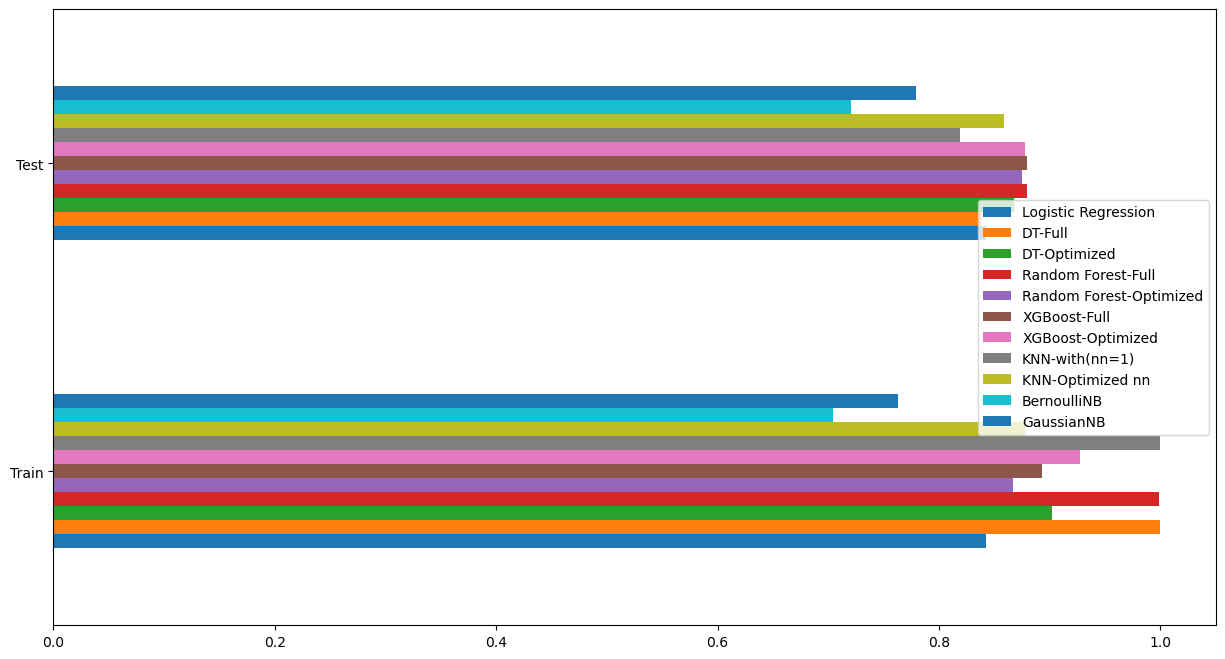

In [63]:
#Accuracy Chart

accuracy_dict={}
for x in scores.keys():
    accuracy_dict.update({x:scores[x]['Accuracy']})
scores_df=pd.DataFrame(accuracy_dict)
scores_df.head()
scores_df.plot(kind='barh', figsize=(15, 8))

<Axes: >

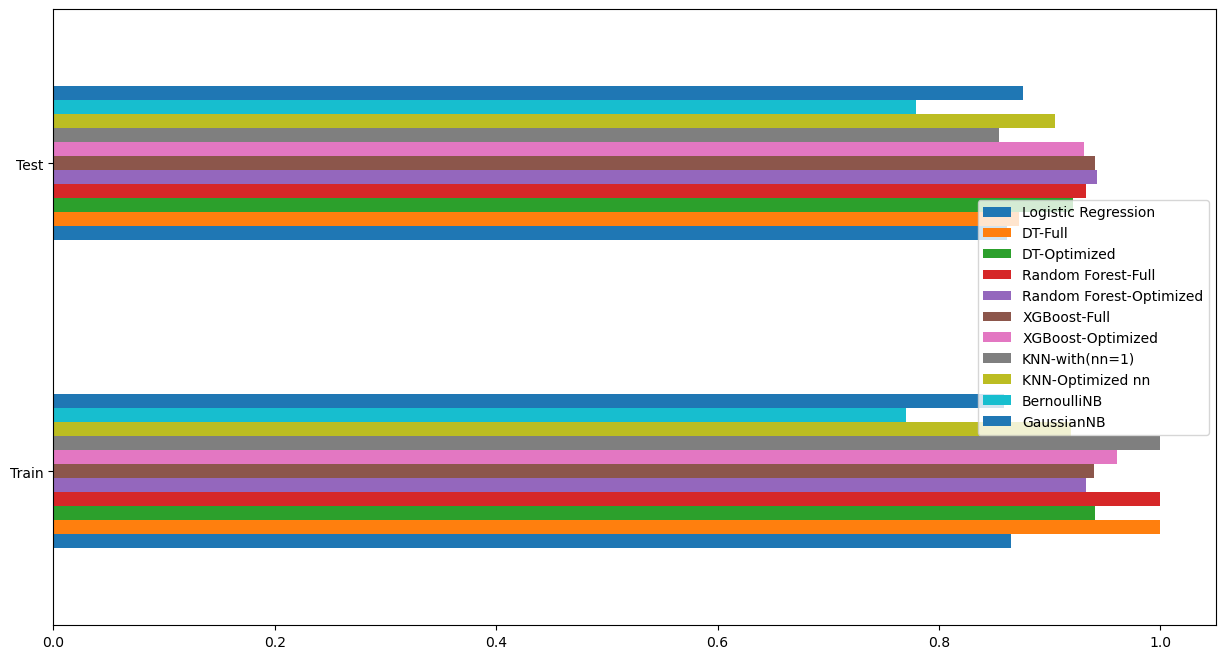

In [64]:
#Precision Chart

precision_dict={}
for x in scores.keys():
    precision_dict.update({x:scores[x]['Precision']})
scores_df=pd.DataFrame(precision_dict)
scores_df.head()
scores_df.plot(kind='barh', figsize=(15, 8))

<Axes: >

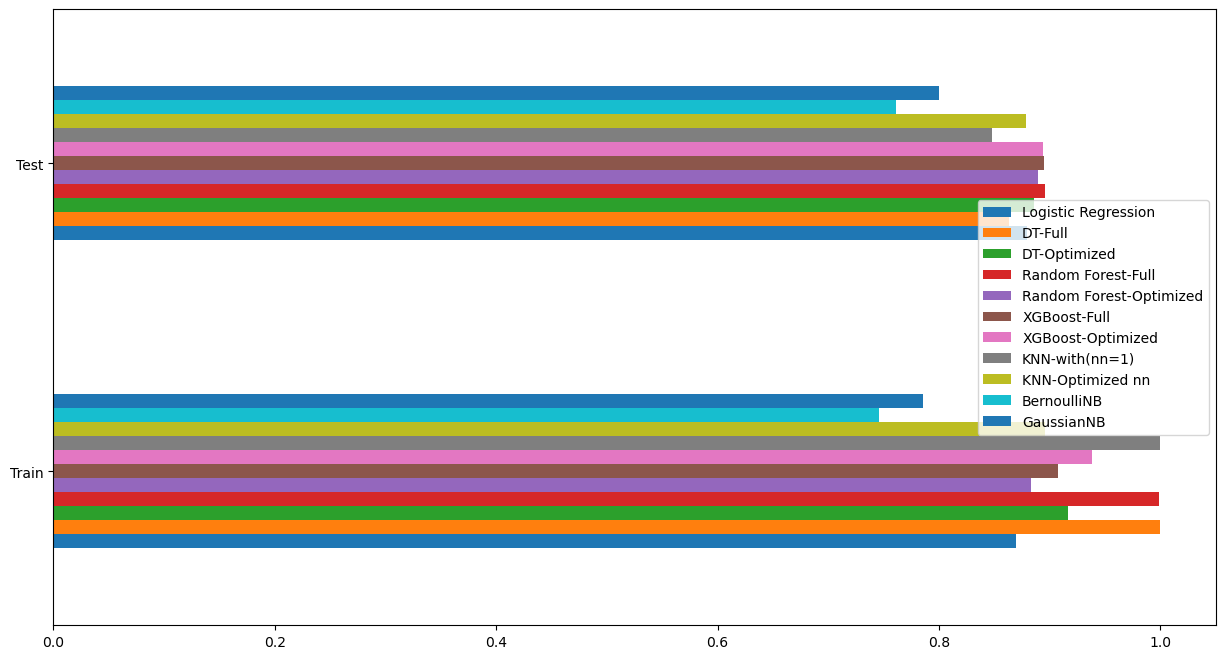

In [65]:
#F-1 Score Chart

f1_dict={}
for x in scores.keys():
    f1_dict.update({x:scores[x]['F-1 Score']})
scores_df=pd.DataFrame(f1_dict)
scores_df.head()
scores_df.plot(kind='barh', figsize=(15, 8))

<Axes: >

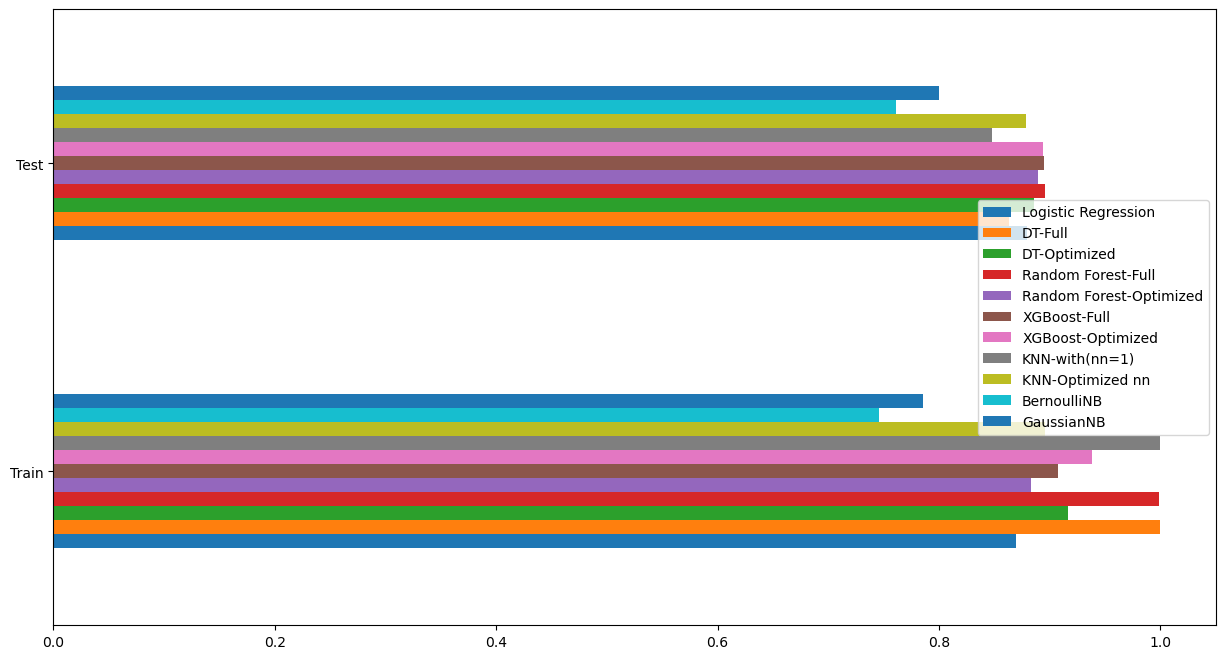

In [66]:
#Recall Chart

Re_dict={}
for x in scores.keys():
    Re_dict.update({x:scores[x]['F-1 Score']})
scores_df=pd.DataFrame(Re_dict)
scores_df.head()
scores_df.plot(kind='barh', figsize=(15, 8))

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Compare all the classification models using their ROC curves.
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

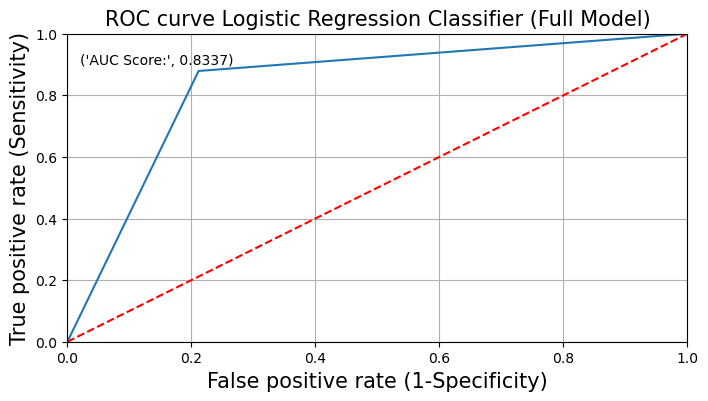

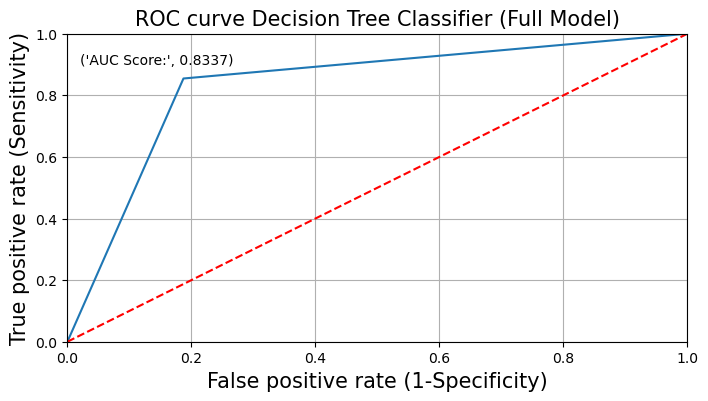

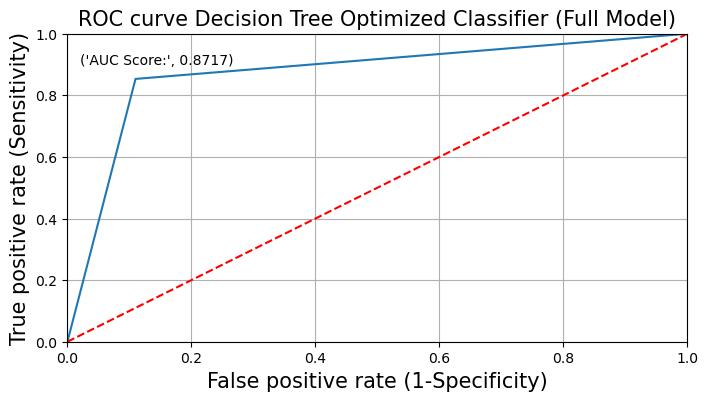

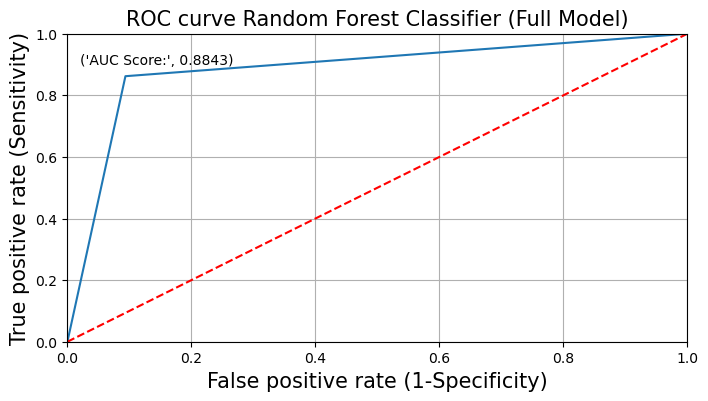

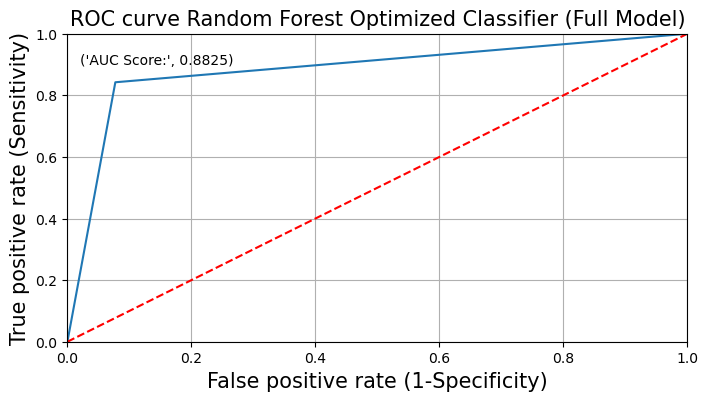

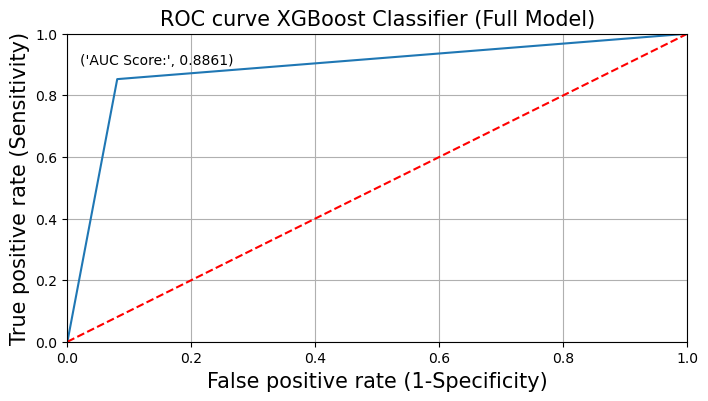

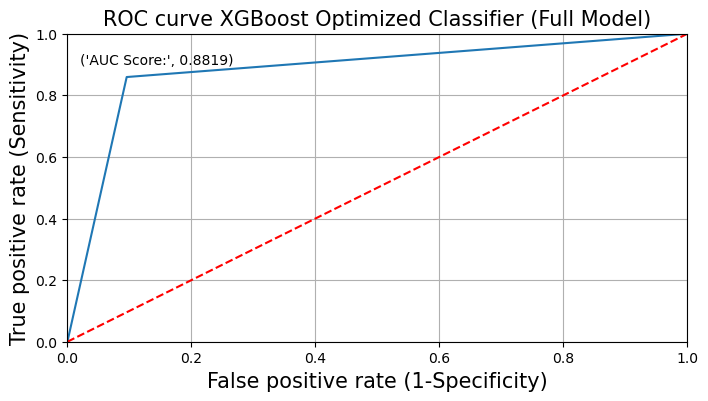

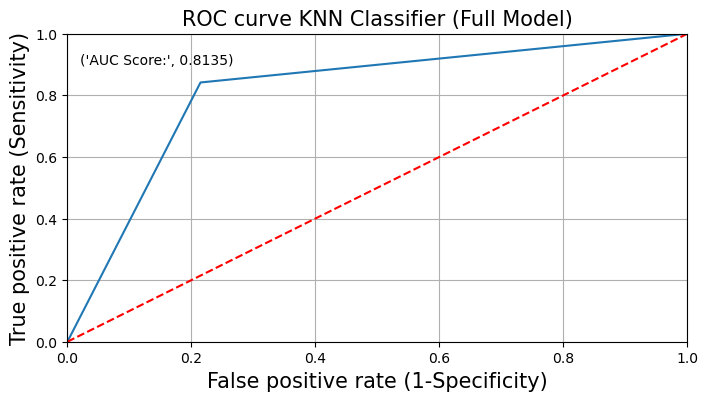

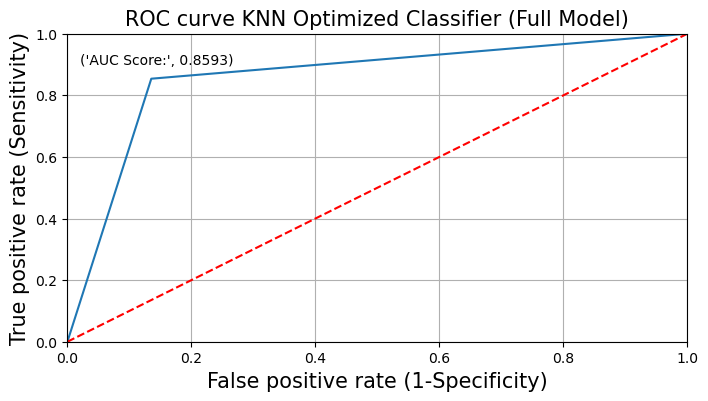

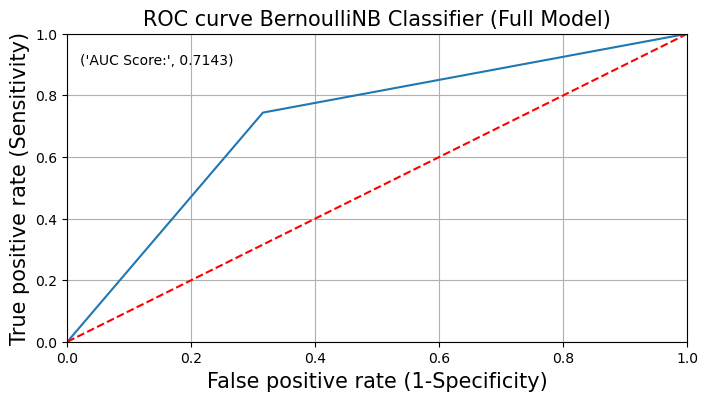

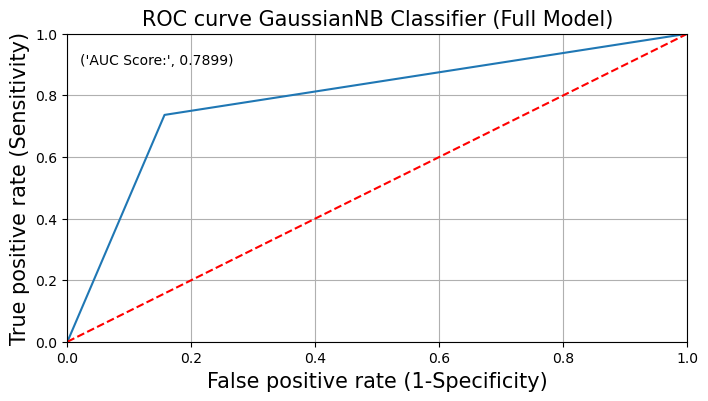

In [78]:
#RoC Curve For All Classification Models

roc_auc_curve_generate(lr_model,X_train, X_test, y_train, y_test,"Logistic Regression")
roc_auc_curve_generate(dt_classifier,X_train, X_test, y_train, y_test,"Decision Tree")
roc_auc_curve_generate(grid_search,X_train, X_test, y_train, y_test,"Decision Tree Optimized")
roc_auc_curve_generate(rf_clf,X_train, X_test, y_train, y_test,"Random Forest")
roc_auc_curve_generate(rf_clf_tuned,X_train, X_test, y_train, y_test,"Random Forest Optimized")
roc_auc_curve_generate(xgboost,X_train, X_test, y_train, y_test,"XGBoost")
roc_auc_curve_generate(grid_search_xgb,X_train, X_test, y_train, y_test,"XGBoost Optimized")
roc_auc_curve_generate(knn,X_train, X_test, y_train, y_test,"KNN")
roc_auc_curve_generate(knn_opt,X_train, X_test, y_train, y_test,"KNN Optimized")
roc_auc_curve_generate(classifer,X_train, X_test, y_train, y_test,"BernoulliNB")
roc_auc_curve_generate(classifer1,X_train, X_test, y_train, y_test,"GaussianNB")


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>comput cross entropy and Compare all the classification models.
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [68]:
#Function for calculating Cross Entropy
def crs_entropy(mdl,X_train, X_test, y_train, y_test,nm):
    # Predict probabilities on test set
    y_prob_crs = mdl.predict_proba(X_test)
    
    # Compute cross-entropy
    cross_entropy = log_loss(y_test, y_prob_crs)
    
    print(f"Cross-Entropy for {nm}: {cross_entropy}")

In [70]:
#Cross Entropy For All Classification Models
crs_entropy(lr_model,X_train, X_test, y_train, y_test,"Logistic Regression")
crs_entropy(dt_classifier,X_train, X_test, y_train, y_test,"Decision Tree")
crs_entropy(grid_search,X_train, X_test, y_train, y_test,"Decision Tree Optimized")
crs_entropy(rf_clf,X_train, X_test, y_train, y_test,"Random Forest")
crs_entropy(rf_clf_tuned,X_train, X_test, y_train, y_test,"Random Forest Optimized")
crs_entropy(xgboost,X_train, X_test, y_train, y_test,"XGBoost")
crs_entropy(grid_search_xgb,X_train, X_test, y_train, y_test,"XGBoost Optimized")
crs_entropy(knn,X_train, X_test, y_train, y_test,"KNN")
crs_entropy(knn_opt,X_train, X_test, y_train, y_test,"KNN Optimized")
crs_entropy(classifer,X_train, X_test, y_train, y_test,"BernoulliNB")
crs_entropy(classifer1,X_train, X_test, y_train, y_test,"GaussianNB")


Cross-Entropy for Logistic Regression: 0.36280635686566653
Cross-Entropy for Decision Tree: 5.843329551473983
Cross-Entropy for Decision Tree Optimized: 1.4847929787866412
Cross-Entropy for Random Forest: 0.5279316378594517
Cross-Entropy for Random Forest Optimized: 0.32630909649081963
Cross-Entropy for XGBoost: 0.28505775442812736
Cross-Entropy for XGBoost Optimized: 0.2912121284090847
Cross-Entropy for KNN: 6.51868924837801
Cross-Entropy for KNN Optimized: 1.0507008463720668
Cross-Entropy for BernoulliNB: 0.6463109297408131
Cross-Entropy for GaussianNB: 0.7897821624691532


## 9. Intrepret your solution based on the results

The provided code snippet calculates the cross entropy for different classification models on training and testing data. Cross entropy is a measure of how well the predicted probabilities match the actual outcomes. By analyzing the cross entropy scores of various models, we can infer which model performs better in terms of predictive accuracy and generalization on unseen data. Models with lower cross entropy values are considered to have better performance in classification tasks.

 The cross-entropy values provide insights into the performance of each classification model. Lower cross-entropy indicates better model performance. Logistic Regression, Random Forest, XGBoost, and their optimized versions have relatively low cross-entropy, suggesting they are effective in capturing the underlying patterns in the data. Decision Tree models, especially the unoptimized one, and KNN models have higher cross-entropy, indicating poorer performance compared to the other models. Naive Bayes models also show moderate performance, with GaussianNB having slightly higher cross-entropy than BernoulliNB. Overall, the optimized versions of models tend to perform better, as seen in the decreased cross-entropy values compared to their unoptimized counterparts.

  The results indicate that the Optimized Random Forest and the regular XGBoost models perform the best among the evaluated models, suggesting their suitability for applications requiring high prediction accuracy. The Logistic Regression also shows strong performance, making it a good choice for problems where model simplicity and interpretability are important. Models like Decision Trees and KNN improve significantly with optimization, indicating the necessity of parameter tuning for better performance. Models with poor initial performance like the regular KNN and Decision Tree illustrate the impact of proper model configuration and the pitfalls of overfitting or inappropriate parameter settings.
  These results emphasize the necessity of model selection and hyperparameter tuning in predictive modeling to optimize performance. The notably lower cross-entropy scores in optimized models versus their regular counterparts particularly highlight the potential pitfalls of neglecting proper model setup, such as overfitting or underfitting.